# 0. Clone Repo & Install Dependencies

In [1]:
# import os
# from google.colab import drive
# drive.mount('/content/drive')

# # Change the current working directory
# os.chdir('/content/drive/MyDrive/git/tensortrade-train')

# # Print the current working directory
# print("New working directory: {0}".format(os.getcwd()))

## 0.1 Clone/update repo

In [2]:
# if not os.path.isdir(os.getcwd()+'/.git'):
#   !git init && git remote add origin https://github.com/dennislwy/tensortrade-train.git && git pull origin master
# else:  # repo already exists, update it
#   !git pull origin master

## 0.2 Install dependencies
Check GPU availability

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
gpu_available = not (gpu_info.find('failed')>=0 or gpu_info.find('not recognized')>=0)
if gpu_available:
  print('GPU available')
  print(gpu_info)
else:
  print('GPU NOT available')
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')

GPU NOT available
Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


Install requirements

In [4]:
# ipywidgets is required to run Plotly in Jupyter Notebook.
# Uncomment and run the following line to install it if required.

#!pip install ipywidgets

In [5]:
# if gpu_available:
#   print("Installing GPU requirement packages")
#   !pip install -r requirements.txt
# else:
#   print("Installing non-GPU requirement packages")
#   !pip install -r requirements.no-gpu.txt

## Imports

In [6]:
import ta

import pandas as pd
import numpy as np
from tensortrade.feed.core import Stream, DataFeed, NameSpace
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.instruments import USD, BTC
from tensortrade.oms.wallets import Wallet, Portfolio

%matplotlib inline

## Load Instruments

In [7]:
from tensortrade.oms.instruments import Instrument

TTC = Instrument("TTC", 8, "TensorTrade Coin")

## Data Preparation
### Load data

In [8]:
training_data_path = 'data/sine-fixed-15m-btc-usdt.csv'
testing_data_path = 'data/sine-fixed-15m-btc-usdt.csv'

In [9]:
# df = pd.read_csv(training_data_path)
# df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
# df['date'] = pd.to_datetime(df['date'])
# df.head()

In [10]:
amp = 50
offset = 100

# amp = 50
offset = 30000

x = np.arange(0, 2 * np.pi, 2 * np.pi / 1001)
y = amp * np.sin(3 * x) + offset

df = pd.DataFrame()
df['close'] = y

### Create the dataset features

In [11]:
from ta.trend import *
from transform import difference, log_and_difference, max_min_normalize, mean_normalize

def add_indicators(df, fillna=False):    
    df['close_diff'] = difference(df['close'], inplace=False)
    df['close_log_diff'] = log_and_difference(df['close'], inplace=False)
    df['close_mean'] = mean_normalize(df['close'], inplace=False)
    
    df['macd_diff'] = macd_diff(df['close'], fillna=fillna)
    
    df['ema10'] = ema_indicator(df['close'], 10, fillna=fillna)
    df['ema25'] = ema_indicator(df['close'], 25, fillna=fillna)
    df['ema50'] = ema_indicator(df['close'], 50, fillna=fillna)

    df['ema25_50_diff'] = df['ema25']-df['ema50']
    df['ema25_50_diff_norm'] = 1-df['ema50']/df['ema25']
    df['trend_ema25_50'] = np.where(df['ema25_50_diff']>0, 1, -1)

    df['ema10_25_diff'] = df['ema10']-df['ema25']
    df['ema10_25_diff_norm'] = 1-df['ema25']/df['ema10']
    df['trend_ema10_25'] = np.where(df['ema10_25_diff']>0, 1, -1)

    df.dropna(axis=0, inplace=True)

    df.reset_index(drop=True, inplace=True)

In [12]:
add_indicators(df, fillna=False)

,close,close_diff,close_log_diff,close_mean,macd_diff,ema10,ema25,ema50,ema25_50_diff,ema25_50_diff_norm,trend_ema25_50,ema10_25_diff,ema10_25_diff_norm,trend_ema10_25
0,30039.861889,0.575407,0.000019,1.126901,-0.112806,30037.011578,30031.602226,30024.034624,7.567602,0.000252,1,5.409352,0.000180,1
1,30040.423161,0.561272,0.000019,1.142768,-0.128502,30037.631866,30032.280760,30024.677312,7.603448,0.000253,1,5.351106,0.000178,1
2,30040.970099,0.546939,0.000018,1.158230,-0.143646,30038.238817,30032.949171,30025.316245,7.632926,0.000254,1,5.289647,0.000176,1
3,30041.502510,0.532411,0.000018,1.173282,-0.158249,30038.832216,30033.607120,30025.951000,7.656119,0.000255,1,5.225096,0.000174,1
4,30042.020205,0.517695,0.000017,1.187917,-0.172326,30039.411851,30034.254280,30026.581165,7.673115,0.000255,1,5.157570,0.000172,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
947,29995.299271,0.936477,0.000031,-0.132890,0.238028,29991.155245,29984.878021,29977.335542,7.542479,0.000252,1,6.277224,0.000209,1
948,29996.237415,0.938144,0.000031,-0.106369,0.230192,29992.079276,29985.751820,29978.076792,7.675029,0.000256,1,6.327455,0.000211,1
949,29997.176893,0.939478,0.000031,-0.079810,0.222274,29993.006115,29986.630672,29978.825815,7.804857,0.000260,1,6.375443,0.000213,1
950,29998.117373,0.940479,0.000031,-0.053222,0.214278,29993.935435,29987.514264,29979.582347,7.931918,0.000265,1,6.421170,0.000214,1


In [13]:
total_data_steps = len(df)
print(total_data_steps)

952


In [14]:
# import ta
# dataset = ta.add_all_ta_features(df, 'open', 'high', 'low', 'close', 'volume', fillna=True)
# dataset.head(3)

### Create Chart Price History Data
Note: It is recommended to create the chart data *after* creating and cleaning the dataset to ensure one-to-one mapping between the historical prices data and the dataset.

In [15]:
price_history = df[['close']]
display(price_history.head(3))

,close
0,30039.861889
1,30040.423161
2,30040.970099


In [16]:
# price_history = df[['date', 'open', 'high', 'low', 'close', 'volume']]
# display(price_history.head(3))

In [17]:
# price_history = dataset[['date', 'open', 'high', 'low', 'close', 'volume']] 
# display(price_history.head(3))

# dataset.drop(columns=['date', 'open', 'high', 'low', 'close', 'volume'], inplace=True)

<AxesSubplot:>

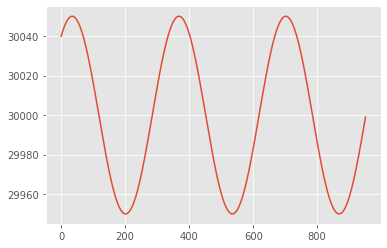

In [18]:
price_history['close'].plot(grid=True)

<AxesSubplot:>

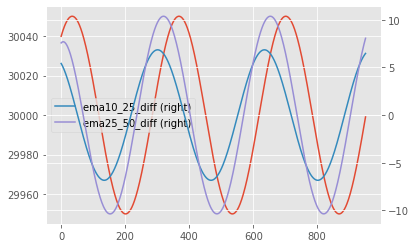

In [19]:
df['close'].plot(grid=True)
df['ema10_25_diff'].plot(grid=True, secondary_y=True, legend=True)
df['ema25_50_diff'].plot(grid=True, secondary_y=True, legend=True)

## Display & Inspect Price History

In [20]:
# !pip install mplfinance

In [21]:
# import mplfinance as mpf
# cd = df.copy()  

# # total data length in dataset
# data_length = len(cd)
# print(f"Total data length: {data_length}")

# Calculate Indicators

In [22]:
# cd.set_index('date', inplace=True)
# cd

# Plot Price History Chart

In [23]:
# #overlays = df[['ema25', 'ema50']]
# apds = [ 
#          #mpf.make_addplot(overlays, width=0.5), 
#          mpf.make_addplot(cd['emaNormDiff'], panel=2, width=0.5, ylabel='EMA\nNormalized\nDiff'),
#          mpf.make_addplot(cd['macd_diff'], panel=3, width=0.5, ylabel='MACD Diff'),
#        ]
# mpf.plot(cd, type='candle', 
#          style='charles', volume=True,
#          title='BTC/USD Full Data (%d steps)\n%s -> %s' % (data_length, cd.index[0], cd.index[data_length-1]), 
#          addplot=apds, figscale=1.2)

In [58]:
import matplotlib.pyplot as plt

def show_chart(df, columns1, columns2, columns3, title):
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle(title)

    df[columns1].plot(ax=axs[0], grid=True)
    df[columns2].plot(ax=axs[1], grid=True)
    df[columns3].plot(ax=axs[2], grid=True)

In [59]:
columns1 = ['close']
columns2 = ['ema10_25_diff', 'ema25_50_diff']
columns3 = ['close_diff', 'trend_ema10_25', 'trend_ema25_50', 'macd_diff']

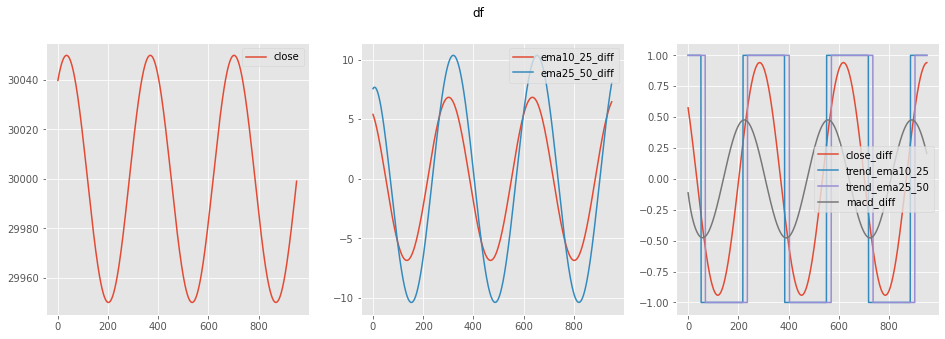

In [60]:
show_chart(df, columns1, columns2, columns3, 'df')

### Create Streams

In [27]:
# Setup stream based on 'Close'
close = Stream.source(price_history['close'].tolist(), dtype="float").rename("USD-TTC")

### Create Data Feeds

In [28]:
# feed with all indicators
# with NameSpace("bitfinex"):
#     streams = [Stream.source(dataset[c].tolist(), dtype="float").rename(c) for c in dataset.columns]

# feed = DataFeed(streams)

In [29]:
# feed with custom indicators
# feed = DataFeed([
#     close,
#     close.rolling(window=10).mean().rename("fast"),
#     close.rolling(window=50).mean().rename("medium"),
#     close.rolling(window=100).mean().rename("slow"),
#     close.log().diff().fillna(0).rename("lr")
# ])

In [30]:
feed = DataFeed([
    #Stream.source(df['close'].tolist(), dtype="float").rename("price"),
    #Stream.source(df['close'].tolist(), dtype="float").diff().fillna(0).rename("price_diff"),
    #Stream.source(df['close'].tolist(), dtype="float").log().diff().fillna(0).rename("price_log_diff"),
    #Stream.source(df['ema25_50_diff_norm'].tolist(), dtype="float").rename("ema25_50_diff_norm"),
    Stream.source(df['close_diff'].tolist(), dtype="float").rename("close_diff"),

    #Stream.source(df['ema10_25_diff'].tolist(), dtype="float").rename("ema10_25_diff"),
    #Stream.source(df['trend_ema10_25'].tolist(), dtype="float").rename("trend_ema10_25"),

    #Stream.source(df['ema25_50_diff'].tolist(), dtype="float").rename("ema25_50_diff"),
    Stream.source(df['trend_ema25_50'].tolist(), dtype="float").rename("trend_ema25_50"),

    #Stream.source(df['macd_diff'].tolist(), dtype="float").rename("macd_diff"),
])

In [31]:
feed.next()

{'close_diff': 0.575406514963106, 'trend_ema25_50': 1}

### Trading Environment Renderers
A renderer is a channel for the trading environment to output its current state. One or more renderers can be attached to the environment at the same time. For example, you can let the environment draw a chart and log to a file at the same time.

Notice that while all renderers can technically be used together, you need to select the best combination to avoid undesired results. For example, PlotlyTradingChart can work well with FileLogger but may not display well with ScreenLogger.

Renderer can be set by name (string) or class, single or list. Available renderers are:
* `'screenlog'` or `ScreenLogger`: Shows results on the screen.
* `'filelog'` or `FileLogger`: Logs results to a file.
* `'plotly'` or `PlotlyTradingChart`: A trading chart based on Plotly.

#### Examples:

* renderers = 'screenlog' (default)
* renderers = ['screenlog', 'filelog']
* renderers = ScreenLogger()
* renderers = ['screenlog', `FileLogger()`]
* renderers = [`FileLogger(filename='example.log')`]

Renderers can also be created and configured first then attached to the environment as seen in a following example.

### Environment with Multiple Renderers
Create PlotlyTradingChart and FileLogger renderers. Configuring renderers is optional as they can be used with their default settings.

With the plotly renderer you must provide an parameter called `renderer_feed`. This is a `DataFeed` instance that provides all the information that is required by a renderer to function.

In [32]:
from tensortrade.env.default.renderers import PlotlyTradingChart, FileLogger

chart_renderer = PlotlyTradingChart(
    display=True,  # show the chart on screen (default)
    height=800,  # affects both displayed and saved file height. None for 100% height.
    save_format="html",  # save the chart to an HTML file
    auto_open_html=True,  # open the saved HTML chart in a new browser tab
)

file_logger = FileLogger(
    filename="example.log",  # omit or None for automatic file name
    path="training_logs"  # create a new directory if doesn't exist, None for no directory
)

### Create Exchange & Portfolio

In [33]:
bitfinex = Exchange("bitfinex", service=execute_order)(
    close
)

initial_capital = 1000

cash = Wallet(bitfinex, initial_capital * USD)
asset = Wallet(bitfinex, 0 * TTC)

portfolio = Portfolio(USD, [
    cash,
    asset
])

### Reward & Action Scheme

In [34]:
from BSH import BSH
from PBR import PBR

reward_scheme="risk-adjusted"
action_scheme="managed-risk"

#reward_scheme = PBR(price=close)    
#action_scheme = BSH(cash=cash, asset=asset).attach(reward_scheme)

### Renderer Feed

In [35]:
renderer_feed = DataFeed([
    Stream.source(price_history[c].tolist(), dtype="float").rename(c) for c in price_history]
)

In [36]:
# renderer_feed = DataFeed([
#     Stream.source(price_history['close'].tolist(), dtype="float").rename("price"),
#     Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
# ])

In [37]:
# renderer_feed = DataFeed([
#     Stream.source(y, dtype="float").rename("price"),
#     Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
# ])

In [38]:
# renderer_feed = DataFeed([
#     price,
#     Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
# ])

In [39]:
# renderer_feed = DataFeed([
#     close
# ])

### Setup Environment

In [40]:
import tensortrade.env.default as default
from PositionChangeChart import PositionChangeChart

window_size = 25

# env = default.create(
#     portfolio=portfolio,
#     action_scheme=action_scheme,
#     reward_scheme=reward_scheme,
#     feed=feed,
#     window_size=window_size,
#     renderer_feed=renderer_feed,
#     renderer=PositionChangeChart()
# )

env = default.create(
    portfolio=portfolio,
    action_scheme=action_scheme,
    reward_scheme=reward_scheme,
    feed=feed,
    window_size=window_size,
    renderer_feed=renderer_feed,
    renderers=[
        chart_renderer, 
        file_logger
    ]
)

## Setup and Train DQN Agent
The green and red arrows shown on the chart represent buy and sell trades respectively. The head of each arrow falls at the trade execution price.

In [41]:
from tensortrade.agents import DQNAgent

episodes = 1
steps = total_data_steps
render_interval = steps

agent = DQNAgent(env)

# Set render_interval to None to render at episode ends only
agent.train(n_episodes=episodes, n_steps=steps, render_interval=render_interval)

====      AGENT ID: d4918238-26d1-433e-a10a-03e4fb49801d      ====


c:\git\dennislee\tensortrade-train\venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


-4579.360091144689

## Direct Performance and Net Worth Plotting
Alternatively, the final performance and net worth can be displayed using pandas via Matplotlib.

In [42]:
def show_performance(df, price_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    fig.suptitle('Performance')

    df.plot(ax=axs[0], grid=True, fontsize=12)
    df.net_worth.plot(ax=axs[1], grid=True, legend=True)
    price_history['close'].plot(ax=axs[1], secondary_y=True, legend=True)

    plt.interactive(True)
    plt.show(block=True)

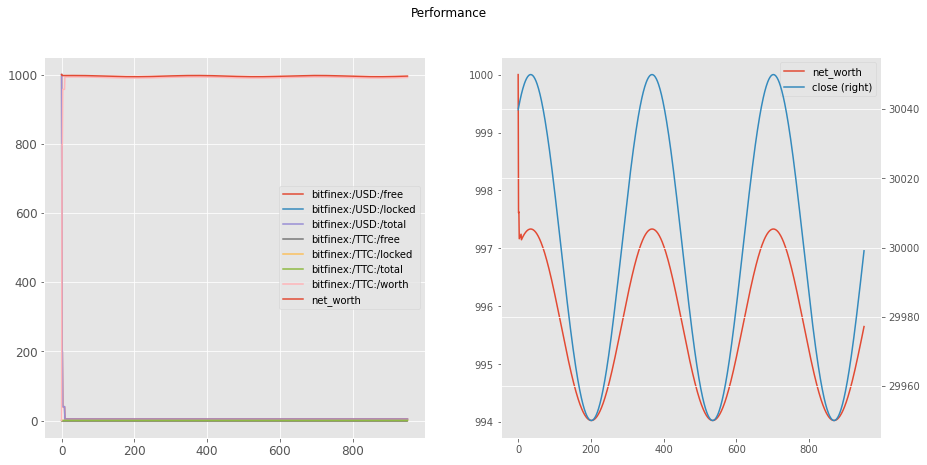

In [43]:
performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
performance.drop(['bitfinex:/USD-TTC'], axis=1, inplace=True)
show_performance(performance, price_history)

In [44]:
net_worth = performance.net_worth[len(performance.net_worth)-1]
print(f"Net worth = {net_worth} USD")

pnl = 100*(net_worth/initial_capital - 1)
print(f"PNL = {pnl} %")

Net worth = 995.6503783696634 USD
PNL = -0.43496216303365864 %


In [45]:
#env.action_scheme.portfolio.performance